# Supplementary 1a: Fragmentation

## Set path to project root

In [1]:
import os
import sys


def find_project_root(marker=".git"):
    current_path = os.getcwd()
    while current_path != os.path.dirname(current_path):  # Stop at the filesystem root
        if marker in os.listdir(current_path):
            return current_path
        current_path = os.path.dirname(current_path)
    return None  # Return None if the marker is not found


project_root = find_project_root()
print(project_root)

# Add project_root to the Python path
sys.path.append(project_root)

/home/yuyang/Project_local/FragBEST-Myo


## Import requried packages

In [2]:
import json

import MDAnalysis as mda
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage

from utils.ppseg.fragment import fragment_on_bonds

## Read/write the files
First, read the reference file (protein with ligand) using `MDAnalysis`. We selected the ligand by `resname 2OW` and convert it to `rdkit.Chem.rdchem.Mol`. Note that elements are needed to RDKit convert; furthermore, to make sure the connection of the atoms is correct, we used `to_guess=["bonds", "elements"]` in `guess_TopologyAttrs()`.  

In [3]:
# ------------------- start of the user-defined parameters -------------------
# set path
ref_filepath = f"{project_root}/dataset/ref/PPS_OMB_min_cg_pl.pdb"
ligand_file_path = f"{project_root}/dataset/ref/PPS_OMB_min_cg_pl_2OW_only.pdb"
# ------------------- end of the user-defined parameters ---------------------

u = mda.Universe(ref_filepath)
u.guess_TopologyAttrs(to_guess=["bonds", "elements"])
molecule = u.select_atoms("resname 2OW").convert_to("RDKIT")

/home/yuyang/Project_local/FragBEST-Myo/.pixi/envs/default/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "


Then, Use `RDKit.Chem` to read the molecule from a PDB file.  

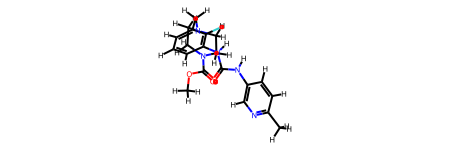

In [4]:
molecule

And, we saved the ligand only file.

In [5]:
u.select_atoms("resname 2OW").write(ligand_file_path)

/home/yuyang/Project_local/FragBEST-Myo/.pixi/envs/default/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


## Fragmentation on bonds
Next, use our developed function `fragment_on_bonds` to fragment the ligand by bonds. Here, we chose the bonds number `3`, `7`, `8`, `13`, `17`.  

In [6]:
# fragment the ligand molecule based on the specified bonds
mol_fragment, mol_f_idx = fragment_on_bonds(
    ligand_file_path, [3, 7, 8, 13, 17], removeHs=False, with_star=False
)

## Visualize the chemical fragments
We then used RDKit's function to visualize them in 2D space. **However, the bond order is not all coverted correctly. Thus, we need to check and manually correct them when visualization.**

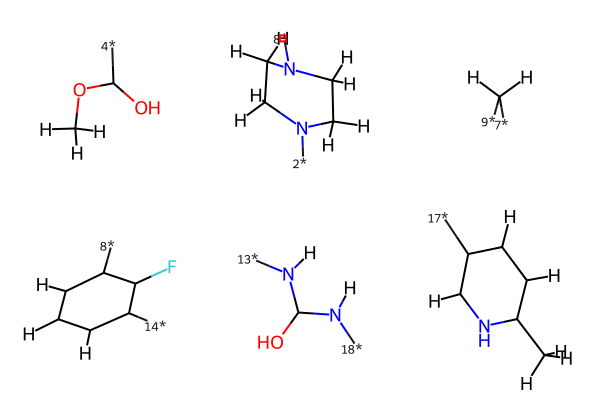

In [7]:
MolsToGridImage(mol_fragment)

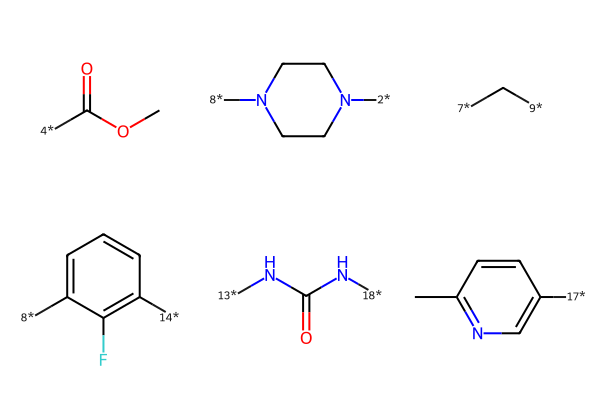

In [8]:
mol_fragment_smiles = [
    Chem.MolToSmiles(mol).replace("(O)", "(=O)") for mol in mol_fragment
]  # fixed the double bonds issues (but loss the conformation)
mol_fragment_smiles = [
    each.replace("C", "c").replace("N", "n") if (idx == 3) | (idx == 5) else each
    for idx, each in enumerate(mol_fragment_smiles)
]  # fixed the atom type issues
mol_fragment_smiles[5] = mol_fragment_smiles[5].replace(
    "(c([H])([H])[H])", "(C([H])([H])[H])"
)
mol_fragment_vis = [Chem.MolFromSmiles(smiles) for smiles in mol_fragment_smiles]
MolsToGridImage(mol_fragment_vis)

## Fragment volume
Another important information should be included is the volume of the fragments. We calculated this by `RDKit`.  

In [9]:
volumes = [AllChem.ComputeMolVolume(mol) for mol in mol_fragment]
print(volumes)

[55.40000000000001, 88.88800000000002, 24.440000000000005, 85.09600000000002, 50.320000000000014, 94.30400000000002]


In our original study, each fragment volume was calculated by averaging its fragment volume in the entire ligand-bound trajectory. Thus, there is a slight difference between the provided fragment information json file (`FragBEST-Myo/utils/ppseg/myo/ligand_fragments_example.json`) and the one generated here. 

## Save fragments information

In [10]:
# ----------------- start of the user-defined parameters -----------------
ligand_fragments_path = f"{project_root}/dataset/ref/ligand_fragments.json"
# ----------------- end of the user-defined parameters -------------------

labels_info = {
    "0": {"name": "out of the threshold"},
    "1": {
        "name": "fragment 1",
        "fragments_idx": mol_f_idx[0],
        "fragment_vol": volumes[0],
    },
    "2": {
        "name": "fragment 2",
        "fragments_idx": mol_f_idx[1],
        "fragment_vol": volumes[1],
    },
    "3": {
        "name": "fragment 3",
        "fragments_idx": mol_f_idx[3],
        "fragment_vol": volumes[3],
    },
    "4": {
        "name": "fragment 4",
        "fragments_idx": mol_f_idx[4],
        "fragment_vol": volumes[4],
    },
    "5": {
        "name": "fragment 5",
        "fragments_idx": mol_f_idx[5],
        "fragment_vol": volumes[5],
    },
    "6": {
        "name": "fragment 6",
        "fragments_idx": mol_f_idx[2],
        "fragment_vol": volumes[2],
    },
}

# save the ligand fragments information
with open(ligand_fragments_path, "w") as f:
    json.dump(labels_info, f, indent=2)